Other plots
====
That I would like to keep but don't fit anywhere else

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from ema import clean, read

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60.]


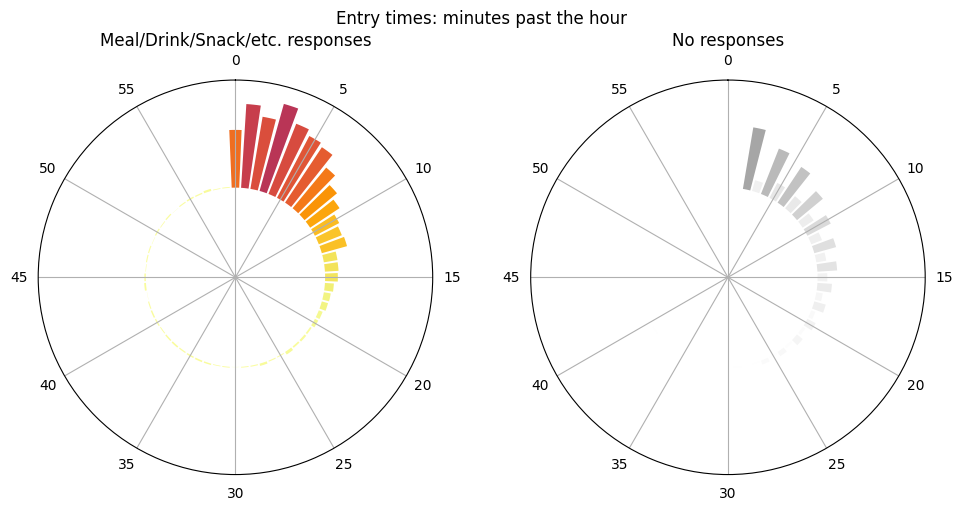

In [7]:
"""
Circular histogram of entries in minutes past the hour

"""
import numpy as np
import matplotlib.pyplot as plt

meal_info = read.all_meal_info()
meal_info = clean.clean_meal_info(meal_info, keep_catchups=False)

no_responses = meal_info["meal_type"] == "No response"

fig, axes = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=(10, 5))


def polar_hist(axis, meal_df, cmap, **kw):
    bins = np.linspace(0, 60, 61)
    radii, _ = np.histogram(meal_df.index.minute, bins=bins)
    print(bins)

    theta = np.linspace(0.0, 2 * np.pi, len(bins) - 1, endpoint=False)
    width = 0.8 * (2 * np.pi) / (len(bins) - 1)

    bars = axis.bar(theta, radii, width=width, bottom=1500, **kw)

    for r, bar in zip(radii, bars):
        bar.set_facecolor(cmap(r / 1000))


polar_hist(axes[0], meal_info[~no_responses], plt.cm.inferno_r)
polar_hist(axes[1], meal_info[no_responses], plt.cm.binary)

for axis in axes:
    n_ticks = 12
    axis.set_xticks(
        [2 * i * np.pi / n_ticks for i in range(n_ticks)],
        [int(i * 60 / n_ticks) for i in range(n_ticks)],
    )

    axis.set_theta_zero_location("N")
    axis.set_theta_direction(-1)

    axis.set_yticks([])

    axis.set_ylim(1000, 2100)

fig.suptitle("Entry times: minutes past the hour")
axes[0].set_title("Meal/Drink/Snack/etc. responses")
axes[1].set_title("No responses")

fig.tight_layout()
fig.savefig("img/clock_hist.png")

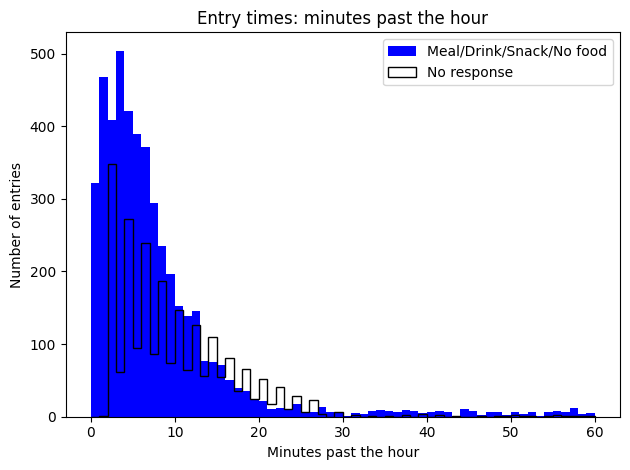

In [8]:
hist_kw = {"bins": np.linspace(0, 60, 61)}

plt.hist(
    meal_info.index.minute[~no_responses],
    **hist_kw,
    color="b",
    label="Meal/Drink/Snack/No food",
    histtype="stepfilled"
)
plt.hist(
    meal_info.index.minute[no_responses],
    **hist_kw,
    color="k",
    label="No response",
    histtype="step"
)

plt.xlabel("Minutes past the hour")
plt.ylabel("Number of entries")
plt.legend()
plt.title("Entry times: minutes past the hour")
plt.tight_layout()
plt.savefig("img/minutes_hist.png")

2 participants ended in Ramadan (but started before)
13 participants entirely within Ramadan
0 participants started in Ramadan (but ended after)
68 participants outside of Ramadan


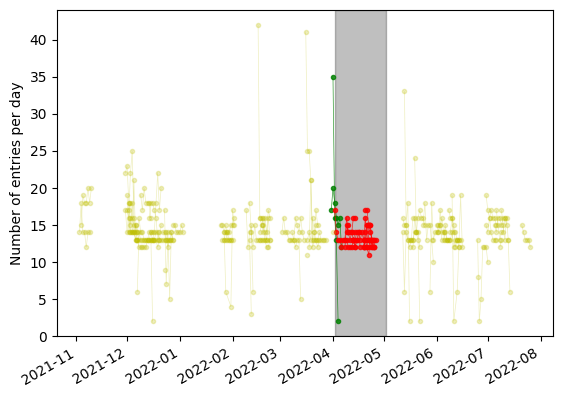

In [31]:
"""
Show when the entries were made, indicating Ramadan

"""
import matplotlib.pyplot as plt
from ema import plotting

meal_df = clean.cleaned_smartwatch(keep_catchups=False)

plot = plt.subplots()
fig, axis = plot
plot_kw = {"alpha": 0.8}

# Slice the dataframe to only include and plot entries:
# - participants who ended in Ramadan (but started before)
green_mask = meal_df["last_in_ramadan"] & ~meal_df["all_in_ramadan"]
print(
    f"{len(meal_df[green_mask]['p_id'].unique())} participants ended in Ramadan (but started before)"
)
plotting.participant_entries_per_day(
    meal_df[green_mask],
    fig_ax=plot,
    color="g",
    **plot_kw,
)

# - participants entirely within Ramadan
red_mask = meal_df["all_in_ramadan"]
print(f"{len(meal_df[red_mask]['p_id'].unique())} participants entirely within Ramadan")
plotting.participant_entries_per_day(
    meal_df[red_mask],
    fig_ax=plot,
    color="r",
    **plot_kw,
)

# - participants who started in Ramadan (but ended after)
blue_mask = meal_df["first_in_ramadan"] & ~meal_df["all_in_ramadan"]
print(
    f"{len(meal_df[blue_mask]['p_id'].unique())} participants started in Ramadan (but ended after)"
)
plotting.participant_entries_per_day(
    meal_df[blue_mask],
    fig_ax=plot,
    color="b",
    **plot_kw,
)

# - participants outside of Ramadan
yellow_mask = ~meal_df["any_in_ramadan"]
print(f"{len(meal_df[yellow_mask]['p_id'].unique())} participants outside of Ramadan")
plotting.participant_entries_per_day(
    meal_df[yellow_mask],
    fig_ax=plot,
    color="y",
)

# Indicate ramadan on the plot
plotting.shade_ramadan(axis)

fig.autofmt_xdate()
fig.savefig("img/ramadan_intersections.png")

# Check there's no overlaps
assert len(meal_df["p_id"].unique()) == len(meal_df[green_mask]["p_id"].unique()) + len(
    meal_df[red_mask]["p_id"].unique()
) + len(meal_df[blue_mask]["p_id"].unique()) + len(
    meal_df[yellow_mask]["p_id"].unique()
)

In [104]:
"""
Build a dataframe for checking ethnicity vs Ramadan, and find a list of participant information for each day of the study

"""
import pandas as pd
from dataclasses import dataclass

# Find which participants took part in/outside of ramadan
meal_df = clean.cleaned_smartwatch(keep_catchups=False)
meal_df[meal_df["first_in_ramadan"]]

# Find the questionnaire or demographic file
qnaire_df = read._qnaire_df()
qnaire_df = qnaire_df[["residents_id", "respondent_ethnicity", "respondent_status"]]

# Keep only actual participants
qnaire_df = qnaire_df[qnaire_df["respondent_status"] == 1]
qnaire_df["respondent_ethnicity"].value_counts(dropna=False)

# Add a column to the meal_df showing participant ethnicity/religion
meal_df = meal_df.reset_index()
meal_df = meal_df.merge(qnaire_df, left_on="p_id", right_on="residents_id")


# Add the start and end date for each participant
feasibility_df = read.smartwatch_feasibility()[
    ["residents_id", "actualdateofdistribution1st", "collectiondate_actual"]
]
meal_df = meal_df.merge(feasibility_df, left_on="p_id", right_on="residents_id")
meal_df = meal_df.set_index("Datetime")

# Find the first and last dates of the study
first, last = meal_df.index.min().date(), meal_df.index.max().date()


@dataclass
class Participant:
    date: pd.Timestamp
    pid: int
    ethnicity: str
    n_entries: int


# List with one element per participant per day
entry_info = []

days = pd.date_range(first, last, freq="1d")
for day in days:
    # Find which participants were active on this day
    df_slice = meal_df[
        (meal_df["actualdateofdistribution1st"] <= day)
        & (meal_df["collectiondate_actual"] >= day)
    ]

    p_ids = df_slice["p_id"].unique()

    for p_id, group in df_slice.groupby("p_id"):
        # Check the ethnicity is always the same for each participant...
        assert len(group["respondent_ethnicity"].unique()) == 1

        # Find the number of entries on this actual day (might be 0)
        n_entries = len(group[group.index.date == pd.to_datetime(day).date()])

        entry_info.append(
            Participant(
                date=day,
                pid=p_id,
                ethnicity=group["respondent_ethnicity"][0],
                n_entries=n_entries,
            )
        )

[Participant(date=Timestamp('2021-11-03 00:00:00'), pid=16231, ethnicity=1.0, n_entries=14),
 Participant(date=Timestamp('2021-11-03 00:00:00'), pid=23158, ethnicity=1.0, n_entries=0),
 Participant(date=Timestamp('2021-11-04 00:00:00'), pid=16231, ethnicity=1.0, n_entries=18),
 Participant(date=Timestamp('2021-11-04 00:00:00'), pid=23158, ethnicity=1.0, n_entries=15),
 Participant(date=Timestamp('2021-11-05 00:00:00'), pid=16231, ethnicity=1.0, n_entries=14),
 Participant(date=Timestamp('2021-11-05 00:00:00'), pid=23158, ethnicity=1.0, n_entries=19),
 Participant(date=Timestamp('2021-11-06 00:00:00'), pid=16231, ethnicity=1.0, n_entries=14),
 Participant(date=Timestamp('2021-11-06 00:00:00'), pid=23158, ethnicity=1.0, n_entries=18),
 Participant(date=Timestamp('2021-11-07 00:00:00'), pid=16231, ethnicity=1.0, n_entries=12),
 Participant(date=Timestamp('2021-11-07 00:00:00'), pid=23158, ethnicity=1.0, n_entries=18),
 Participant(date=Timestamp('2021-11-08 00:00:00'), pid=16231, ethnicit